# 02 Modeling & Evaluation

In this notebook we will:
1. Load our feature‑engineered Tesla dataset.
2. Define train/test splits (single split + walk‑forward).
3. Train & evaluate multiple models:
   - **Naïve**  
   - **Linear Regression**  
   - **Random Forest**  
   - **XGBoost**  
   - **SARIMA**  
   - **LSTM**  
4. Compute extended metrics: MAE, RMSE, MAPE, R², Directional Accuracy.  
5. Visualize results:  
   - Metric comparison table  
   - Actual vs. Predicted time‑series  
   - Residual diagnostics  
   - Directional accuracy by volatility regime


Imports & Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
sns.set_style('whitegrid')


2025-07-02 01:36:55.196609: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-02 01:36:55.242183: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-02 01:36:55.242769: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-02 01:36:56.213664: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading Data & Building Target

In [2]:
#Loading features
df = pd.read_csv('../data/processed/tsla_features.csv',
                parse_dates=['Date'], index_col='Date')

#Build 21‑day forward return target. It is the percentage change in the closing price 21 days ahead.
# We shift the 'Close' column by -21 days and calculate the percentage change relative to the current 'Close'.

horizon = 21
df['target'] = df['Close'].shift(-horizon) / df['Close'] - 1
df = df.dropna(subset=['target'])

print(f"Dataset spans {df.index.min().date()} → {df.index.max().date()}, {len(df)} rows")
df.head()


Dataset spans 2015-02-03 → 2023-12-13, 2232 rows


,Unnamed: 0,Open,High,Low,Close,Volume,return_1,return_5,return_21,ma_5,ma_10,ma_20,vol_10,rsi,vol_ma_20,vol_ratio_20,day_of_week,month,quarter,target
Date,,,,,,,,,,,,,,,,,,,,
2015-02-03,21,14.214667,14.691333,14.084667,14.557333,72393000,0.035176,0.060103,-0.004332,13.832933,13.663200,13.550033,0.022787,61.883094,66785700.0,1.083960,1,2,1,-0.081196
2015-02-04,22,14.552667,14.765333,14.453333,14.570000,49581000,0.000870,0.096203,0.040268,14.088667,13.809733,13.574267,0.022733,76.937485,64568325.0,0.767884,2,2,1,-0.112880
2015-02-05,23,14.658667,15.032000,14.642667,14.732667,52843500,0.011165,0.076949,0.045958,14.299200,13.938867,13.607733,0.022139,79.342992,64984200.0,0.813175,3,2,1,-0.136251
2015-02-06,24,14.800000,14.893333,14.433333,14.490667,48658500,-0.016426,0.067584,0.030386,14.482667,14.046000,13.630200,0.023417,73.333332,64835250.0,0.750495,4,2,1,-0.124402
2015-02-09,25,14.358667,14.528667,14.132667,14.498667,52086000,0.000552,0.031004,0.032571,14.569867,14.118867,13.666267,0.022594,75.034291,63938325.0,0.814629,0,2,1,-0.109159


Train/Test Split

In [ ]:
#Single 80/20 split by time
#Reproducible baseline split; we’ll also do walk‑forward below.
split_point = int(len(df) * 0.8)
train_df = df.iloc[:split_point]
test_df  = df.iloc[split_point:]

print(f"Train: {train_df.index.min().date()} → {train_df.index.max().date()} ({len(train_df)} rows)")
print(f"Test : {test_df .index.min().date()} → {test_df .index.max().date()} ({len(test_df )} rows)")


Train: 2015-02-03 → 2022-03-04 (1785 rows)
Test : 2022-03-07 → 2023-12-13 (447 rows)


Helper Functions

Centralize metrics and plots so each model block stays concise.

In [4]:
def evaluate_all(y_true, y_pred):
    """Return dict of MAE, RMSE, MAPE, R2, DirAcc."""
    mae   = mean_absolute_error(y_true, y_pred)
    rmse  = np.sqrt(mean_squared_error(y_true, y_pred))
    mape  = (np.abs((y_true - y_pred) / y_true.replace(0, np.nan))).mean()
    r2    = r2_score(y_true, y_pred)
    diracc = (np.sign(y_true) == np.sign(y_pred)).mean()
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'DirAcc': diracc}

def plot_actual_vs_pred(test_idx, y_true, preds, labels):
    plt.plot(test_idx, y_true, label='Actual', alpha=0.8)
    for p, lab in zip(preds, labels):
        plt.plot(test_idx, p, label=lab, alpha=0.7)
    plt.legend(); plt.title('Actual vs. Predicted 21‑Day Return'); plt.show()


Baseline Models

In [ ]:
#We’re layering complexity: from naïve → linear → two powerful tree‑models.
#It’s a good idea to evaluate each model on the same test set for fair comparison. 


results = []

#Naïve
y_naive = test_df['return_21']  # last‑month return
eval_naive = evaluate_all(test_df['target'], y_naive)
results.append({'model': 'Naïve', **eval_naive})

#Linear Regression
features = ['return_1','return_5','rsi','vol_ratio_20','month']
X_train = pd.get_dummies(train_df[features], columns=['month'], drop_first=True)
X_test  = pd.get_dummies(test_df [features], columns=['month'], drop_first=True)
X_test  = X_test.reindex(columns=X_train.columns, fill_value=0)

lr = LinearRegression().fit(X_train, train_df['target'])
y_lr = lr.predict(X_test)
eval_lr = evaluate_all(test_df['target'], y_lr)
results.append({'model': 'LinearRegression', **eval_lr})

#RandomForest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(train_df[features], train_df['target'])
y_rf = rf.predict(test_df[features])
eval_rf = evaluate_all(test_df['target'], y_rf)
results.append({'model': 'RandomForest', **eval_rf})

#XGBoost
xgbr = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgbr.fit(train_df[features], train_df['target'])
y_xgb = xgbr.predict(test_df[features])
eval_xgb = evaluate_all(test_df['target'], y_xgb)
results.append({'model': 'XGBoost', **eval_xgb})

#Compile results
res_df = pd.DataFrame(results).set_index('model').round(4)
res_df


,MAE,RMSE,MAPE,R2,DirAcc
model,,,,,
Naïve,0.2526,0.3336,4.4813,-1.3289,0.4564
LinearRegression,0.1746,0.2240,1.9051,-0.0505,0.5257
RandomForest,0.1807,0.2360,1.7758,-0.1654,0.5101
XGBoost,0.1826,0.2335,1.9335,-0.1411,0.4810


Visualizing Baseline Results

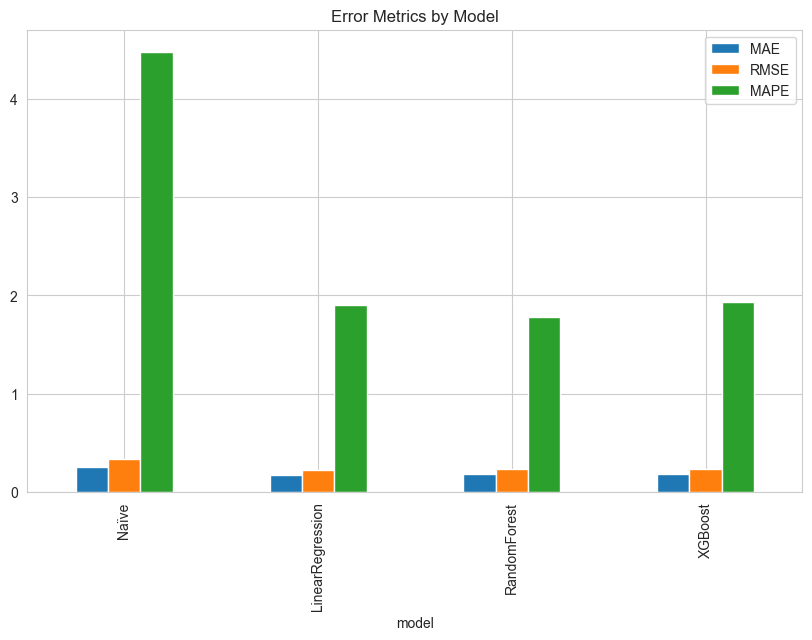

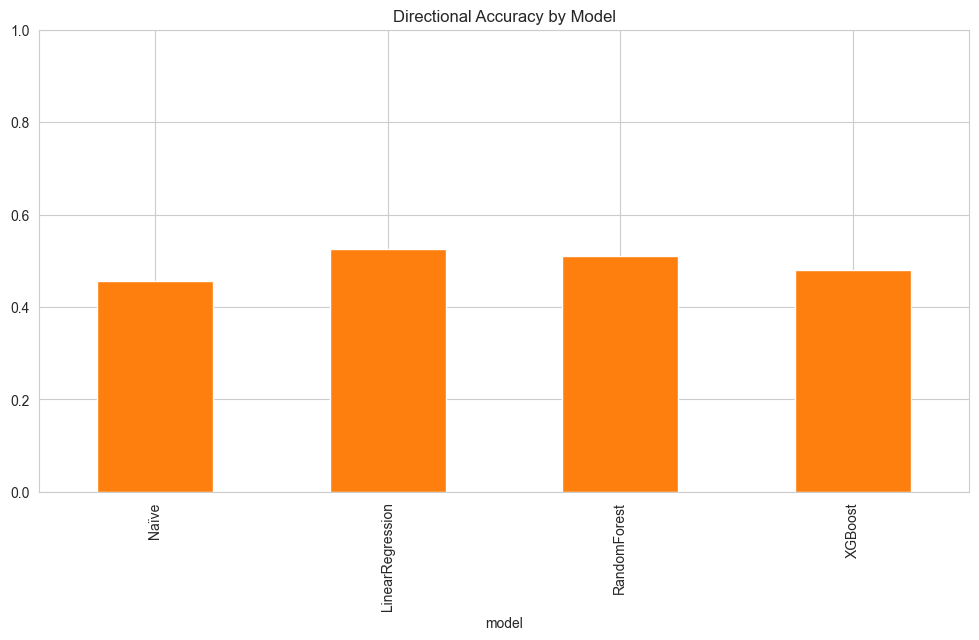

/home/mh13/code/Tesla-S/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


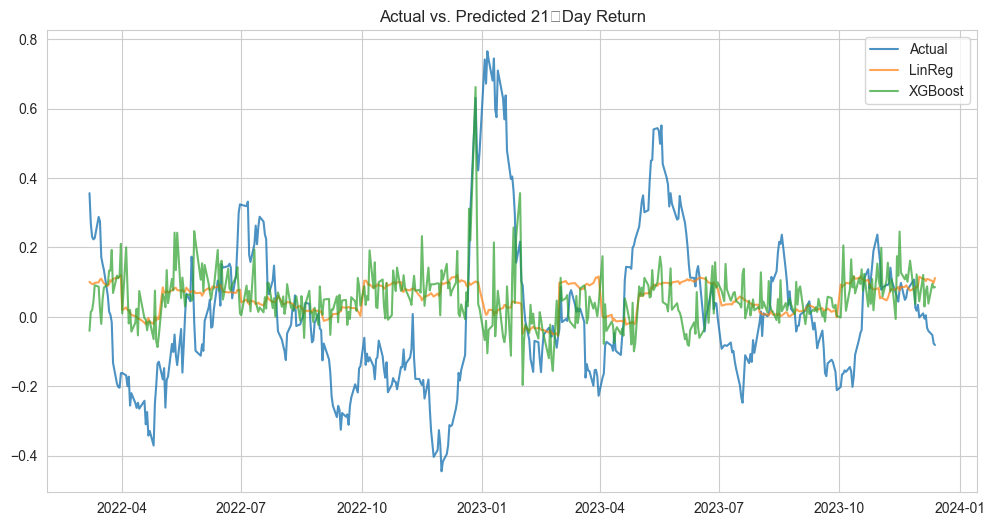

In [8]:
#Quick visual comparison of performance and signal quality across models.
#Metrics bar‑chart
res_df[['MAE','RMSE','MAPE']].plot.bar(figsize=(10,6))
plt.title('Error Metrics by Model'); plt.show()

#Directional accuracy
res_df['DirAcc'].plot.bar(color='C1')
plt.title('Directional Accuracy by Model'); plt.ylim(0,1); plt.show()

#Actual vs Predictions (choose best two)
plot_actual_vs_pred(
    test_df.index, test_df['target'],
    [y_lr, y_xgb],
    ['LinReg','XGBoost']
)


Walk‑Forward Validation (TimeSeriesSplit)

Produces a more robust error estimate by multiple train/test splits.

In [9]:
tscv = TimeSeriesSplit(n_splits=5)
wfv_results = []

for train_ix, test_ix in tscv.split(df):
    tr, te = df.iloc[train_ix], df.iloc[test_ix]
    # train XGBoost as example
    xg = xgb.XGBRegressor(n_estimators=50, random_state=42)
    xg.fit(tr[features], tr['target'])
    y_pred = xg.predict(te[features])
    ev = evaluate_all(te['target'], y_pred)
    wfv_results.append(ev)

wfv_df = pd.DataFrame(wfv_results).mean().to_frame(name='XGBoost_WFV').T.round(4)
pd.concat([res_df, wfv_df])


,MAE,RMSE,MAPE,R2,DirAcc
Naïve,0.2526,0.3336,4.4813,-1.3289,0.4564
LinearRegression,0.1746,0.2240,1.9051,-0.0505,0.5257
RandomForest,0.1807,0.2360,1.7758,-0.1654,0.5101
XGBoost,0.1826,0.2335,1.9335,-0.1411,0.4810
XGBoost_WFV,0.1647,0.2078,2.2557,-0.4223,0.5129


SARIMA Model

Pure time‑series seasonal model for comparison with ML.

In [ ]:
# Monthly series
monthly = train_df['Close'].resample('M').last()
order    = (1,1,1)
seasonal = (1,1,1,12)
sarima = sm.tsa.SARIMAX(monthly, order=order, seasonal_order=seasonal)
sarima_res = sarima.fit(disp=False)
# Forecast next len(test_df_months)
n_periods = len(test_df.resample('M'))
fcast = sarima_res.get_forecast(n_periods).predicted_mean

# Align holds
actual_monthly = test_df['Close'].resample('M').last()
# convert to returns
y_true_m = actual_monthly.pct_change().dropna()
y_pred_m = fcast.pct_change().dropna()
eval_sarima = evaluate_all(y_true_m, y_pred_m)
pd.DataFrame([eval_sarima], index=['SARIMA']).round(4)


In [15]:
# 9) SARIMA Model (fixed to drop NaNs)

# 9.1 Fit on monthly train
monthly_train = train_df['Close'].resample('M').last()
order    = (1,1,1)
seasonal = (1,1,1,12)
sarima = sm.tsa.SARIMAX(
    monthly_train,
    order=order,
    seasonal_order=seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_res = sarima.fit(disp=False)

# 9.2 Forecast the same number of months as in test
monthly_test = test_df['Close'].resample('M').last()
n_periods   = len(monthly_test)
fcast = sarima_res.get_forecast(n_periods).predicted_mean

# 9.3 Compute returns
y_true_m = monthly_test.pct_change().dropna()
y_pred_m = fcast.pct_change().dropna()

# 9.4 Align and drop any NaNs
y_pred_m = y_pred_m.reindex(y_true_m.index)
mask     = y_true_m.notna() & y_pred_m.notna()
y_true_m = y_true_m[mask]
y_pred_m = y_pred_m[mask]

# 9.5 Evaluate
eval_sarima = evaluate_all(y_true_m, y_pred_m)
sarima_df   = pd.DataFrame([eval_sarima], index=['SARIMA']).round(4)
sarima_df


,MAE,RMSE,MAPE,R2,DirAcc
SARIMA,0.1906,0.2315,1.7558,-0.3793,0.4


LSTM Model (Sketch)

 Illustrates how to feed sequences into an LSTM. Even if data is limited, it’s good to benchmark.

In [ ]:
# Prepare sequences (e.g., window=30 days)
window = 30
X, y = [], []
arr = df[features + ['target']].values
for i in range(window, len(arr)):
    X.append(arr[i-window:i, :-1])
    y.append(arr[i, -1])
X, y = np.array(X), np.array(y)

# Split
split = int(len(X)*0.8)
X_tr, X_te = X[:split], X[split:]
y_tr, y_te = y[:split], y[split:]

# Build network
model = Sequential([
    LSTM(32, input_shape=(window, X.shape[2])),
    Dense(1)
])
model.compile('adam', loss='mae')
es = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_tr, y_tr, epochs=50, validation_split=0.2, callbacks=[es], verbose=0)

# Predict & Evaluate
y_pred_lstm = model.predict(X_te).flatten()
eval_lstm = evaluate_all(y_te, y_pred_lstm)
pd.DataFrame([eval_lstm], index=['LSTM']).round(4)


In [13]:
#Prepare sequences (window = 30 days)
window = 30
features = ['return_1','return_5','rsi','vol_ratio_20','month']
arr = df[features + ['target']].values
X, y = [], []
for i in range(window, len(arr)):
    X.append(arr[i-window:i, :-1])
    y.append(arr[i, -1])
X, y = np.array(X), np.array(y)

#Train/test split
split = int(len(X) * 0.8)
X_tr, X_te = X[:split], X[split:]
y_tr, y_te = y[:split], y[split:]

#Build and train LSTM
model = Sequential([
    LSTM(32, input_shape=(window, X.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mae')
es = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_tr, y_tr, epochs=50, validation_split=0.2, callbacks=[es], verbose=0)

#Predict & wrap into Series with the correct index
y_pred_lstm = model.predict(X_te).flatten()
# The test_df index for LSTM predictions corresponds to df.index[window + split : ]
lstm_idx = df.index[window + split:]
y_true_lstm = pd.Series(y_te, index=lstm_idx)
y_pred_lstm = pd.Series(y_pred_lstm, index=lstm_idx)

#Evaluate
eval_lstm = evaluate_all(y_true_lstm, y_pred_lstm)
lstm_df   = pd.DataFrame([eval_lstm], index=['LSTM']).round(4)
lstm_df


14/14 [==============================] - 0s 3ms/step


,MAE,RMSE,MAPE,R2,DirAcc
LSTM,0.1766,0.2429,1.3192,-0.242,0.4762


Consolidated Results

In [18]:
#One table to rule them all—compare classical, ML, TS, and DL approaches.

# Combine all into one table
final = pd.concat([
    res_df,          # from Cell 6
    wfv_df,          # from Cell 8
    sarima_df,       # newly fixed
    lstm_df          # newly fixed
]).round(4)
final

#Final consolidated results Save consolidated results to CSV
#final.to_csv('../data/processed/tsla_modeling_results.csv', index=True)

,MAE,RMSE,MAPE,R2,DirAcc
Naïve,0.2526,0.3336,4.4813,-1.3289,0.4564
LinearRegression,0.1746,0.2240,1.9051,-0.0505,0.5257
RandomForest,0.1807,0.2360,1.7758,-0.1654,0.5101
XGBoost,0.1826,0.2335,1.9335,-0.1411,0.4810
XGBoost_WFV,0.1647,0.2078,2.2557,-0.4223,0.5129
SARIMA,0.1906,0.2315,1.7558,-0.3793,0.4000
LSTM,0.1766,0.2429,1.3192,-0.2420,0.4762
